<h1 style="line-height:2em;">
PANDAPROSUMER EXAMPLE:<br>
BOOSTER HEAT PUMP (BHP)
</h1>

Example prepared by:
--------------------
    Izak Oberčkal Pluško, Marko Keber, Katja Klinar, Tine Seljak*, Andrej Kitanovski

    Faculty of Mechanical Engineering, University of Ljubljana, Slovenia
    
    *Contact: tine.seljak@fs.uni-lj.si

DESCRIPTION:
--------------------
This example describes how to create a single booster heat pump element in *pandaprosumer* and connect it to a single consumer. The user can choose the pump's type, while the consumer demand and source data for each time step is read from an Excel input file and is stored in a pandas dataframe. 

![network](figures/bhp_demand_1.png)

Glossary:
---------
- Network: a configuration of connected energy sources and energy consumers
- Element: a single energy source or a single energy consumer
- Container: a pandaprosumer data structure that contains data of an individual element; each element must have its container 
- Controller: the logic of an element that defines its behaviour and its limits
- General controller: the first controller in the network that interacts with controllers of all other elements; this controller also manages external data
- Map / mapping: a connection between two elements; contains information about the what is exchanged between the elements

Network design philosophy:
--------------------------
In pandaprosumer, a system's component is represented by a network element. Each element is assigned a *container* and its own *element controller*. A container is a structure that contains the component's configuration data (static input data), which can include information that will not change in the analysis such as size, etc. The behaviour of an element is governed by its *controller*. Connections between elements are defined by *mappings*, which couple output parameters of one controller to the input parameter of a controller of a connected element. 
The network is managed by a *general controller* called *ConstProfileController*. This controller is connected to all element controllers and manages time-dependent input data from external sources (e.g. Excel file). For each time step it distributes the time-dependent input data to relevant element controllers. 

CREATING A NETWORK:
--------------------

If we are not in pandaprosumer parent directory, we should add it to the path so that the program knows where to find the necessary functions:

In [55]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

1 - Input data:
---------------

First let's import libraries required for data management.

In [56]:
import pandas as pd
from pandapower.timeseries.data_sources.frame_data import DFData

Next we need to define the properties of the BHP, i.e. characteristics that don't change during an analysis. We choose the BHP type and assign it a name.

In [57]:
bhp_type = 'water-water1'
bhp_name = 'example_bhp'

We define the period of the analysis by setting its start and end, which have the form "YYYY-MM-DD HH:MM:SS". The time resolution is given in [s]. 

In [58]:
start = '2020-01-01 00:00:00'
end = '2020-01-01 23:59:59'
time_resolution = 900        # 15 min
frequency = '15min'

Now we import our time-dependent data and transform it into an appropriate DFData object. DFData is a pandaprosumer object that stores all data of an individual element. The DFData object is limited by the duration of the analysis defined above.

In [59]:
time_series_data = pd.read_excel('data/input_bhp.xlsx')

dur = pd.date_range(start=start, end=end, freq=frequency, tz='utc')
time_series_data.index = dur
time_series_input = DFData(time_series_data)

print(time_series_data.head())

                               time  mode  t_source_k  q_demand_kw
2020-01-01 00:00:00+00:00  00:00:00     3         280            0
2020-01-01 00:15:00+00:00  00:15:00     3         280            0
2020-01-01 00:30:00+00:00  00:30:00     3         280            0
2020-01-01 00:45:00+00:00  00:45:00     3         280            0
2020-01-01 01:00:00+00:00  01:00:00     3         280            0


2 - Creating elements of the network:
----------------------------------------

In this example, the network is made up of two elements: an energy source and an energy consumer. The source is represented by a single BHP element and the consumer is modelled by a single heat demand element.  

![elements](figures/bhp_demand_2.png)

First we define an empty prosumer *container* object. Each element of the network has its own container, which is later filled with data and results.

In [60]:
from pandaprosumer.create import create_empty_prosumer_container

bhp_prosumer = create_empty_prosumer_container()

Then we define the period of the analysis using time data for the analysis given above in Section 1.

In [61]:
from pandaprosumer.create import create_period

period = create_period(bhp_prosumer, time_resolution, start, end, 'utc', 'default')

2.1. General element:

In a pandaprosumer network, the first element is a general controller (*Const Profile controller*). It reads time-dependent input data (*input_params*) and sends it to other elements of the network (*output_params*). The element's data is stored in the *ConstProfileControllerData* class. The controller (*ConstProfileController*) for this element is created with the  *create_controlled_const_profile* function. At this point, we pass to the general controller element the previously created prosumer container, titles of data columns (*input_params*) in the input file (Excel file, in this case) and the coresponding names of output columns (*output_params*), the period of the analysis and the time-dependent data in the DFData object.

In [62]:
from pandaprosumer.create_controlled import create_controlled_const_profile

input_params = ['mode', 't_source_k', 'q_demand_kw']
result_params = ['mode_cp', 't_source_cp_k', 'q_demand_cp_kw']

cp_index = create_controlled_const_profile(
    bhp_prosumer, input_params, result_params, period, time_series_input)

2.2. BHP element:

We define the BHP element to which we pass the prosumer container and the data that defines the BHP instance, i.e. BHP type and its name.

In [63]:
from pandaprosumer.create_controlled import create_controlled_booster_heat_pump

bhp_index = create_controlled_booster_heat_pump(bhp_prosumer, bhp_type, bhp_name, level = 1 )

2.3. Heat demand element:

Finally, we create the consumer, which is simulated with the heat demand element. We pass the prosumer container to it. The auxiliary scaling parameter allows us to easily adjust the demanded heat by simply scaling it.

In [64]:
from pandaprosumer.create_controlled import create_controlled_heat_demand

heat_demand_index = create_controlled_heat_demand(bhp_prosumer, scaling=1.0, level = 1, order =1)

3 - Creating connections (mappings) between controllers:
---------------------------------------------------------

![connections](figures/bhp_demand_3.png)

For each controller we define how it is connected to other controllers. In this case we use *Generic Mapping*. The main parameter for the map is the flow of thermal energy (*q_floor_kw*): the output energy flow of one element is linked with the input energy flow of the connected element. 

In [65]:
from pandaprosumer.mapping import GenericMapping

3.1. Connection GENERAL CONTROLLER ---> BHP:

The general controller (*initiator_column*) instructs the BHP controller (*responder_column*) what value to use for *t_source_k* and *mode*. 

In [66]:
GenericMapping(bhp_prosumer,
                   initiator_id=cp_index,
                   initiator_column="t_source_cp_k",
                   responder_id=bhp_index,
                   responder_column="t_source_k",
);
GenericMapping(bhp_prosumer,
                   initiator_id=cp_index,
                   initiator_column="mode_cp",
                   responder_id=bhp_index,
                   responder_column="mode",
);

3.2. Connection BHP ---> HEAT DEMAND (consumer):

The BHP controller (*initiator_column*) informs the heat demand controller (*responder_column*) of how much thermal power (*q_floor*) it can supply at each time step. 

In [67]:
GenericMapping(bhp_prosumer,
                   initiator_id=bhp_index,
                   initiator_column="q_floor",
                   responder_id=heat_demand_index,
                   responder_column="q_received_kw",
);

3.3. Connection GENERAL CONTROLLER ---> HEAT DEMAND (consumer):

The general controller (*initiator_column*) sends the heat demand controller (*responder_column*) information about the actual demand (*q_demand_kw*) at each time step.

In [68]:
GenericMapping(bhp_prosumer,
                   initiator_id=cp_index,
                   initiator_column="q_demand_cp_kw",
                   responder_id=heat_demand_index,
                   responder_column="q_demand_kw",
);

RUNNING THE ANALYSIS:
-----------------------

We can now run the analysis with the input data defined above. 

In [69]:
from pandaprosumer.run_time_series import run_timeseries

run_timeseries(bhp_prosumer, period)

100%|██████████| 96/96 [00:02<00:00, 39.36it/s]


PRINTING AND PLOTTING RESULTS:
----------------------------------

First, we plot the evolution of the demand from the Excel file. 

In [70]:
import matplotlib.pyplot as plt

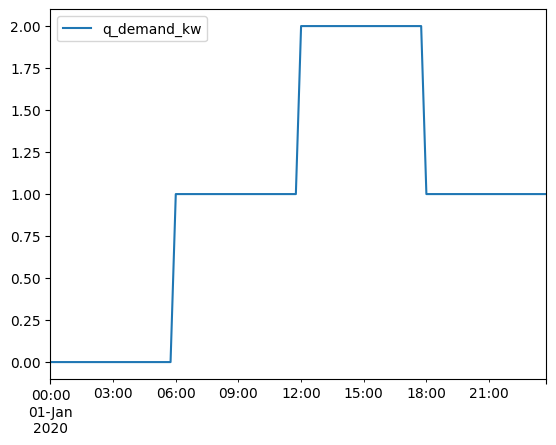

In [71]:
time_series_data.plot(y='q_demand_kw');
plt.show()

In [72]:
print(bhp_prosumer.heat_demand)

   name  scaling  in_service
0  None      1.0        True


We then list the available results for the BHP element. Results are stored in the form of time series, which can be plotted on a graph. The *.time_series* command lists all input and output dataframes. 

In [73]:
print(bhp_prosumer.time_series)

          name            element  element_index  period_index data_source
0  example_bhp  booster_heat_pump            0.0           0.0      DFData
1         None        heat_demand            0.0           0.0      DFData


Here *.data_source* lists all available dataframes that we then specify with the *index* key in *.loc[]*.

In [74]:
print(bhp_prosumer.time_series.data_source)

0    DFData
1    DFData
Name: data_source, dtype: object


Before plotting we have to look at the resulting dataframe to see which quantity (column) do we want to plot. Index can be an integer or the defined name of specific component you want to look at.

In [75]:
print(bhp_prosumer.time_series.data_source.loc[0].df.head())

                           cop_floor  cop_radiator  p_el_floor  p_el_radiator  \
2020-01-01 00:00:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:15:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:30:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:45:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 01:00:00+00:00   4.107815      3.782815         0.0            0.0   

                           q_remain  q_floor  q_radiator  
2020-01-01 00:00:00+00:00       0.0      0.0         0.0  
2020-01-01 00:15:00+00:00       0.0      0.0         0.0  
2020-01-01 00:30:00+00:00       0.0      0.0         0.0  
2020-01-01 00:45:00+00:00       0.0      0.0         0.0  
2020-01-01 01:00:00+00:00       0.0      0.0         0.0  


In [76]:
res_df = bhp_prosumer.time_series
res_df.set_index('name', inplace=True)
print(res_df.loc[bhp_name].data_source.df.head())

                           cop_floor  cop_radiator  p_el_floor  p_el_radiator  \
2020-01-01 00:00:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:15:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:30:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:45:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 01:00:00+00:00   4.107815      3.782815         0.0            0.0   

                           q_remain  q_floor  q_radiator  
2020-01-01 00:00:00+00:00       0.0      0.0         0.0  
2020-01-01 00:15:00+00:00       0.0      0.0         0.0  
2020-01-01 00:30:00+00:00       0.0      0.0         0.0  
2020-01-01 00:45:00+00:00       0.0      0.0         0.0  
2020-01-01 01:00:00+00:00       0.0      0.0         0.0  


Now we can plot the evolution of COP of the booster heat pump.

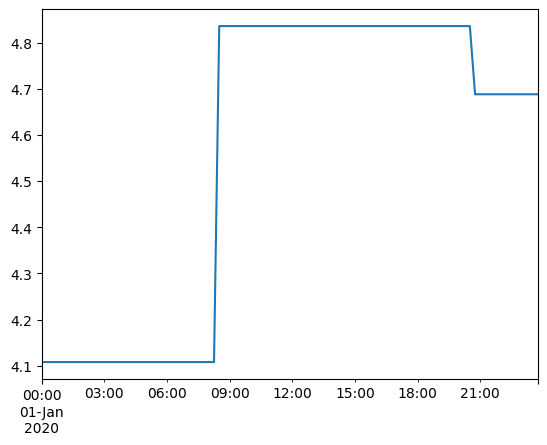

In [77]:
bhp_prosumer.time_series.data_source.loc[bhp_name].df.cop_floor.plot()
plt.show()

We can also for example plot the evolution of the electrical power (floor) of the booster heat pump.

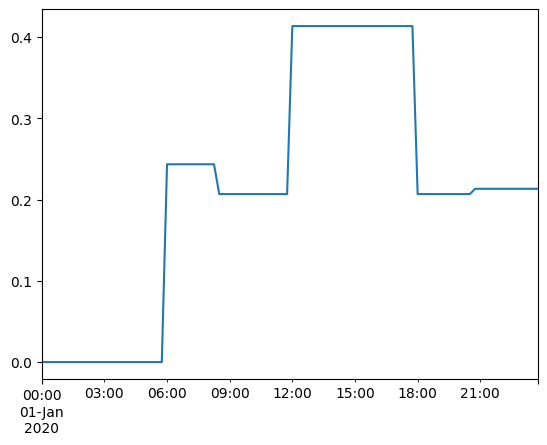

In [78]:
bhp_prosumer.time_series.data_source.loc[bhp_name].df.p_el_floor.plot()
plt.show()

ACKNOWLEDGEMENTS:
-----------------
The authors would like to thank Pratikshya Mohanty and Odile Capron from the Fraunhofer Institute for the help in preparing this tutorial. Special thanks also to Pawel Lytaev and colleagues from the University of Kassel for their code reviews and suggestions during the development of the models. Support from the Senergy Nets project, funded by the European Union under the Horizon Europe program (Grant Agreement No. 101075731) is gratefully acknowledged. 